# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

Notes:
Address is a key feature. Try to get it. Zip_code from address wil dramatically improve results.
And use ohe for more cat features.

### Business Problem

### Objective

### Summary of Results

In [276]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [277]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [278]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [279]:
time0 = time.time()

with open('../input/lc-800k-sample/LCLoans_141_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd']

df = df[features_tokeep]


df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
df = df[df.year_issued.isin([2018])]
    
df = df.sample(100000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(100000, 67)

1.453800916671753

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,Current,8000.0,8000.0,8000.0,36.0,16.46,283.079987,2018-06-01,debt_consolidation,Debt consolidation,w,Individual,C,C5,694.0,tennis pro,3 years,RENT,70000.0,017xx,MA,24.500000,Not Verified,19.0,NaN,NaN,NaN,NaN,NaN,0.0,Apr-1999,0.0,2.0,0.0,8.0,2.0,0.0,20.0,5252.0,42019.0,18863.0,94.3,1137.0,51.0,5.0,5.0,20000.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,42019.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0
1,Current,20000.0,20000.0,20000.0,36.0,22.35,767.440002,2018-07-01,debt_consolidation,Debt consolidation,w,Joint App,D,D5,669.0,Fleet Mgr,< 1 year,RENT,80000.0,951xx,CA,23.690001,Not Verified,6.0,NaN,NaN,54.0,NaN,NaN,3.0,May-2007,3.0,11.0,4.0,23.0,12.0,0.0,34.0,1850.0,42548.0,15651.0,37.8,9898.0,6.0,10.0,21.0,41400.0,0.0,0.0,0.0,1.0,1.0,132000.0,17.26,Not Verified,42548.0,0.0,0.0,50.000000,100.000000,3.0,0.0,0.0,0.0,0.0,0.0,2018.0
2,Current,16000.0,16000.0,15975.0,36.0,6.07,487.260010,2018-04-01,small_business,Business,f,Individual,A,A2,734.0,NaN,NaN,RENT,85000.0,980xx,WA,31.490000,Not Verified,5.0,15.0,NaN,NaN,15.0,15.0,1.0,Dec-2002,0.0,0.0,0.0,24.0,5.0,0.0,36.0,2765.0,63587.0,39339.0,45.2,35314.0,19.0,7.0,18.0,87000.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,63587.0,0.0,0.0,0.000000,97.199997,0.0,1.0,0.0,0.0,0.0,0.0,2018.0
3,Charged Off,15000.0,15000.0,15000.0,36.0,10.47,487.329987,2018-07-01,credit_card,Credit card refinancing,w,Individual,B,B2,679.0,Operator,4 years,RENT,110000.0,360xx,AL,16.680000,Source Verified,4.0,NaN,NaN,NaN,NaN,NaN,3.0,Feb-2008,1.0,3.0,3.0,13.0,10.0,0.0,25.0,4460.0,57977.0,16823.0,54.8,4856.0,4.0,6.0,10.0,30700.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,57977.0,416.0,0.0,33.299999,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2018.0
4,Current,18000.0,18000.0,18000.0,36.0,10.47,584.789978,2018-08-01,credit_card,Credit card refinancing,w,Individual,B,B2,679.0,Mechanic,8 years,RENT,56400.0,346xx,FL,34.939999,Source Verified,7.0,NaN,NaN,NaN,NaN,NaN,1.0,Jan-2012,0.0,0.0,1.0,12.0,2.0,0.0,17.0,3701.0,44414.0,16904.0,77.9,4351.0,7.0,8.0,9.0,21700.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,44414.0,0.0,0.0,71.400002,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2018.0


In [280]:
### feature description:

f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])


73    The number of open credit lines in the borrowe...
Name: desc, dtype: object

99    The total number of credit lines currently in ...
Name: desc, dtype: object

In [281]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,Current,8000.0,8000.0,8000.0,36.0,16.46,283.079987,2018-06-01,debt_consolidation,Debt consolidation,w,Individual,C,C5,694.0,tennis pro,3 years,RENT,70000.0,017xx,MA,24.500000,Not Verified,19.0,NaN,NaN,NaN,NaN,NaN,0.0,1999-04-01,0.0,2.0,0.0,8.0,2.0,0.0,20.0,5252.0,42019.0,18863.0,94.3,1137.0,51.0,5.0,5.0,20000.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,42019.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,6,2018,19.168087,0.000000
1,Current,20000.0,20000.0,20000.0,36.0,22.35,767.440002,2018-07-01,debt_consolidation,Debt consolidation,w,Joint App,D,D5,669.0,Fleet Mgr,< 1 year,RENT,80000.0,951xx,CA,23.690001,Not Verified,6.0,NaN,NaN,54.0,NaN,NaN,3.0,2007-05-01,3.0,11.0,4.0,23.0,12.0,0.0,34.0,1850.0,42548.0,15651.0,37.8,9898.0,6.0,10.0,21.0,41400.0,0.0,0.0,0.0,1.0,1.0,132000.0,17.26,Not Verified,42548.0,0.0,0.0,50.000000,100.000000,3.0,0.0,0.0,0.0,0.0,0.0,2018.0,7,2018,11.167923,0.089542
2,Current,16000.0,16000.0,15975.0,36.0,6.07,487.260010,2018-04-01,small_business,Business,f,Individual,A,A2,734.0,NaN,NaN,RENT,85000.0,980xx,WA,31.490000,Not Verified,5.0,15.0,NaN,NaN,15.0,15.0,1.0,2002-12-01,0.0,0.0,0.0,24.0,5.0,0.0,36.0,2765.0,63587.0,39339.0,45.2,35314.0,19.0,7.0,18.0,87000.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,63587.0,0.0,0.0,0.000000,97.199997,0.0,1.0,0.0,0.0,0.0,0.0,2018.0,4,2018,15.332279,0.000000
3,Charged Off,15000.0,15000.0,15000.0,36.0,10.47,487.329987,2018-07-01,credit_card,Credit card refinancing,w,Individual,B,B2,679.0,Operator,4 years,RENT,110000.0,360xx,AL,16.680000,Source Verified,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2008-02-01,1.0,3.0,3.0,13.0,10.0,0.0,25.0,4460.0,57977.0,16823.0,54.8,4856.0,4.0,6.0,10.0,30700.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,57977.0,416.0,0.0,33.299999,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2018.0,7,2018,10.412260,0.000000
4,Current,18000.0,18000.0,18000.0,36.0,10.47,584.789978,2018-08-01,credit_card,Credit card refinancing,w,Individual,B,B2,679.0,Mechanic,8 years,RENT,56400.0,346xx,FL,34.939999,Source Verified,7.0,NaN,NaN,NaN,NaN,NaN,1.0,2012-01-01,0.0,0.0,1.0,12.0,2.0,0.0,17.0,3701.0,44414.0,16904.0,77.9,4351.0,7.0,8.0,9.0,21700.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,44414.0,0.0,0.0,71.400002,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2018.0,8,2018,6.581928,0.000000


In [282]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Current                                                58358
Fully Paid                                             30144
Charged Off                                             9520
Late (31-120 days)                                      1114
In Grace Period                                          651
Late (16-30 days)                                        192
Default                                                   21
Does not meet the credit policy. Status:Charged Off        0
Does not meet the credit policy. Status:Fully Paid         0
Issued                                                     0
Name: loan_status, dtype: int64

(39685, 72)

Fully Paid                                             30144
Charged Off                                             9520
Default                                                   21
Current                                                    0
Does not meet the credit policy. Status:Charged Off        0
Does not meet the credit policy. Status:Fully Paid         0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Late (31-120 days)                                         0
Name: loan_status, dtype: int64

loan_status                       39685
loan_amnt                         39685
funded_amnt                       39685
funded_amnt_inv                   39685
term                              39685
int_rate                          39685
installment                       39685
issue_d                           39685
purpose                           39685
title                             39685
initial_list_status               39685
application_type                  39685
grade                             39685
sub_grade                         39685
fico_range_high                   39685
emp_title                         35520
emp_length                        36199
home_ownership                    39685
annual_inc                        39685
zip_code                          39685
addr_state                        39685
dti                               39563
verification_status               39685
mo_sin_rcnt_tl                    39685
mths_since_last_delinq            17793


30.666552543640137

### Feature Preprocessing

In [283]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    12597
2.0      3630
0.0      3353
3.0      3342
1.0      2713
4.0      2497
5.0      2455
6.0      1822
7.0      1468
8.0      1329
9.0       993
Name: emp_length, dtype: int64

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
3,15000.0,15000.0,15000.0,36.0,10.47,487.329987,credit_card,Credit card refinancing,w,Individual,B,B2,679.0,Operator,4.0,RENT,110000.0,360,AL,16.680000,Source Verified,4.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,3.0,3.0,13.0,10.0,0.0,25.0,4460.0,57977.0,16823.0,54.8,4856.0,4.0,6.0,10.0,30700.0,0.0,0.0,0.0,0.0,0.0,57977.0,416.0,0.0,33.299999,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2018.0,7,2018,10.412260,0.0,1.0,0.136364,0.053163,0,0.152936,0.040545,0.527064,0.527064,0.279091,0,0.520000,0
5,25000.0,25000.0,25000.0,60.0,20.89,674.789978,debt_consolidation,Debt consolidation,w,Individual,D,D4,669.0,ASSET/MAIL SERVICES MANAGER,10.0,RENT,58000.0,300,GA,31.469999,Not Verified,10.0,NaN,71.0,NaN,NaN,NaN,3.0,0.0,0.0,3.0,22.0,5.0,2.0,54.0,9673.0,212825.0,27201.0,41.0,4433.0,10.0,20.0,20.0,66211.0,0.0,0.0,0.0,0.0,0.0,212825.0,0.0,0.0,44.400002,98.000000,3.0,0.0,0.0,0.0,NaN,0.0,2018.0,11,2018,12.917445,0.0,0.0,0.431034,0.139612,0,0.468983,0.166776,3.669397,3.669397,1.141569,0,0.407407,0
6,10000.0,10000.0,10000.0,60.0,6.08,193.710007,credit_card,Credit card refinancing,w,Individual,A,A2,684.0,Certified Pharmacy Technician,2.0,RENT,38000.0,801,CO,19.080000,Not Verified,35.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,5.0,0.0,0.0,10.0,4429.0,17716.0,12911.0,56.1,8313.0,35.0,3.0,4.0,23000.0,0.0,0.0,0.0,0.0,0.0,17716.0,154.0,0.0,50.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,2,2018,13.755245,0.0,0.0,0.263158,0.061172,0,0.339763,0.116553,0.466211,0.466211,0.605263,0,0.500000,0
9,7500.0,7500.0,7500.0,36.0,19.42,276.519989,other,Other,w,Individual,D,D3,679.0,NaN,NaN,RENT,28000.0,112,NY,17.660000,Verified,4.0,NaN,NaN,NaN,NaN,NaN,5.0,0.0,0.0,1.0,11.0,10.0,0.0,15.0,761.0,8372.0,8372.0,44.5,3408.0,4.0,9.0,11.0,18800.0,0.0,0.0,0.0,0.0,0.0,8372.0,0.0,0.0,66.699997,100.000000,5.0,0.0,0.0,0.0,0.0,0.0,2018.0,6,2018,12.085122,0.0,0.0,0.267857,0.118509,0,0.299000,0.027179,0.299000,0.299000,0.671429,0,0.733333,0
14,6000.0,6000.0,6000.0,36.0,16.14,211.360001,debt_consolidation,Debt consolidation,w,Individual,C,C4,709.0,9-1-1 Telecommunicator,2.0,MORTGAGE,30000.0,551,MN,28.799999,Source Verified,2.0,81.0,NaN,NaN,81.0,81.0,3.0,1.0,1.0,4.0,10.0,6.0,1.0,32.0,5895.0,58950.0,876.0,7.5,8640.0,5.0,3.0,6.0,11700.0,0.0,0.0,0.0,0.0,0.0,58747.0,1418.0,0.0,0.000000,96.900002,1.0,1.0,0.0,0.0,0.0,0.0,2018.0,8,2018,11.748359,0.0,1.0,0.200000,0.084544,0,0.029200,0.196500,1.965000,1.958233,0.390000,0,0.312500,0


In [284]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



loan_amnt                         39685
funded_amnt                       39685
funded_amnt_inv                   39685
term                              39685
int_rate                          39685
installment                       39685
purpose                           39685
title                             39685
initial_list_status               39685
application_type                  39685
grade                             39685
sub_grade                         39685
fico_range_high                   39685
emp_title                         35520
emp_length                        36199
home_ownership                    39685
annual_inc                        39685
zip_code                          39685
addr_state                        39685
dti                               39563
verification_status               39685
mo_sin_rcnt_tl                    39685
mths_since_last_delinq            39685
mths_since_last_major_derog       39685
mths_since_last_record            39685


In [285]:
df.mo_sin_rcnt_tl.describe()

count    39685.000000
mean         7.906942
std          8.816819
min          0.000000
25%          3.000000
50%          5.000000
75%         10.000000
max        260.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [286]:
df.verification_status.value_counts()

Source Verified    15866
Not Verified       15387
Verified            8432
Name: verification_status, dtype: int64

In [287]:
df.target.mean()

0.24041829406576792

In [288]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type', 'grade', 'home_ownership']

In [289]:
df.application_type.value_counts()

Individual    34506
Joint App      5179
Name: application_type, dtype: int64

### EDA

In [290]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,39685.000000,39685.000000,39685.000000
mean,15325.837891,15325.837891,15322.222656
std,9981.283203,9981.283203,9980.894531
min,1000.000000,1000.000000,750.000000
25%,7800.000000,7800.000000,7800.000000
50%,12175.000000,12175.000000,12150.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    29324
60.0    10361
Name: term, dtype: int64

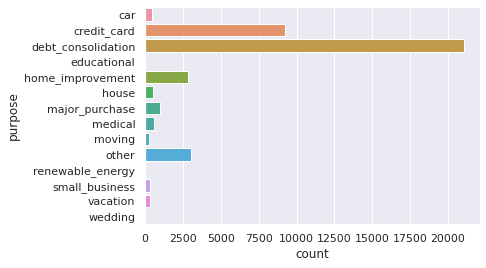

<AxesSubplot:xlabel='count', ylabel='emp_length'>

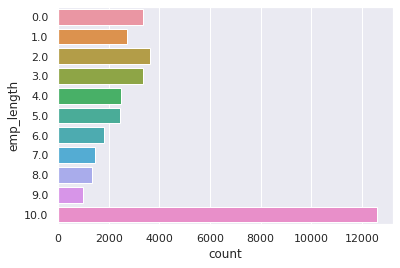

In [291]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [292]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [293]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    9541.000000
mean        0.252070
std         0.737067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        13.000000
Name: delinq_2yrs, dtype: float64

count    30144.000000
mean         0.225683
std          0.735760
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: delinq_2yrs, dtype: float64

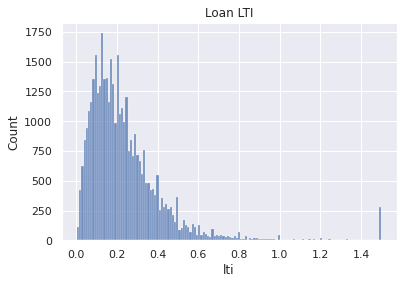

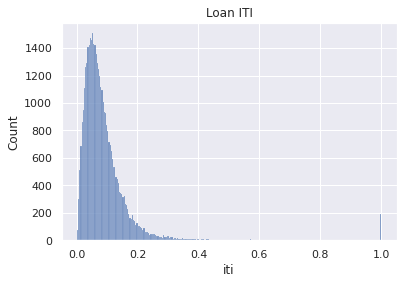

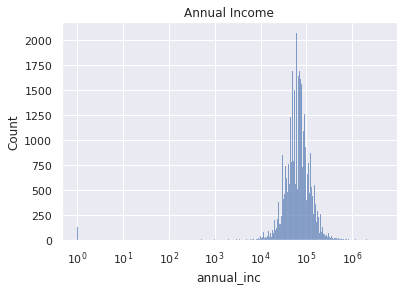

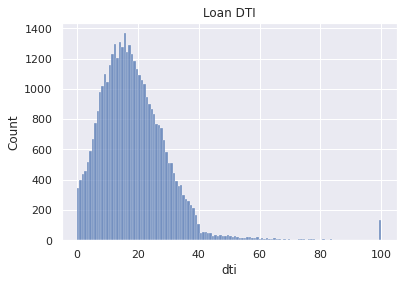

In [294]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [295]:
df.dti.describe()

count    39563.000000
mean        18.795090
std         11.777496
min          0.000000
25%         10.975000
50%         17.260000
75%         24.715000
max        100.000000
Name: dti, dtype: float64

[Text(0.5, 1.0, 'Loan Grade')]

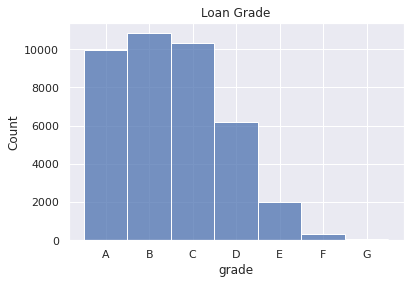

In [296]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

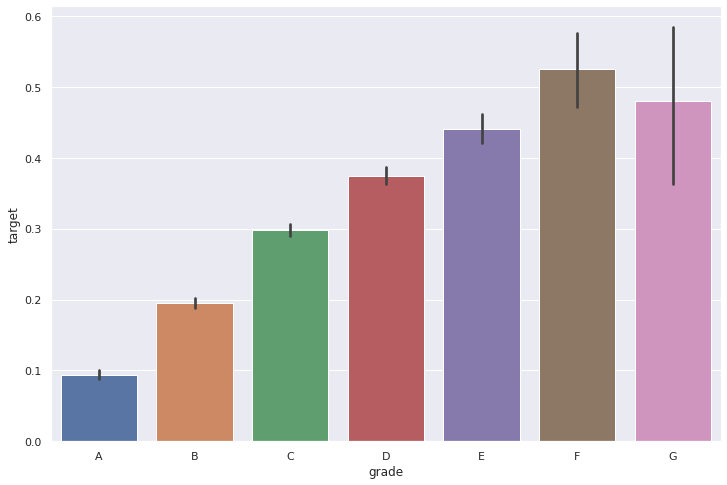

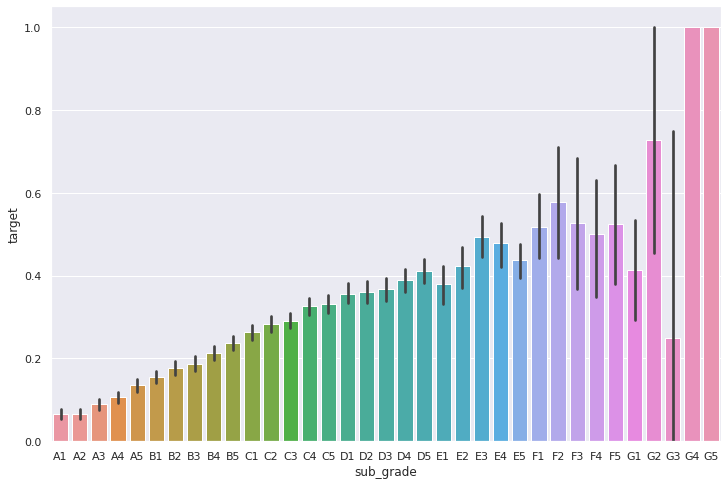

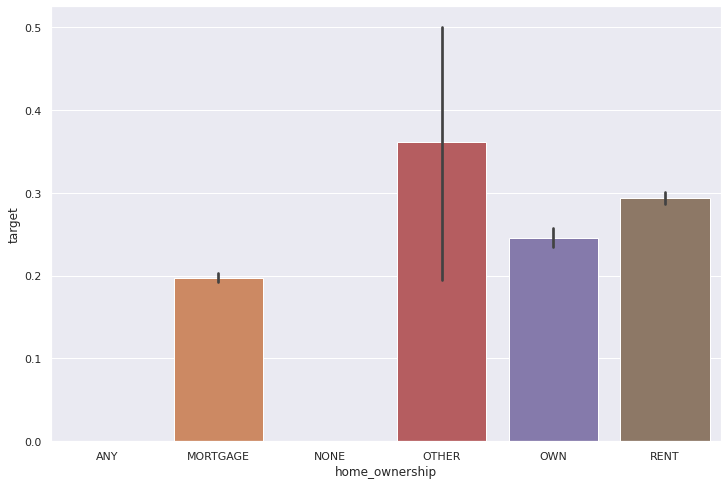

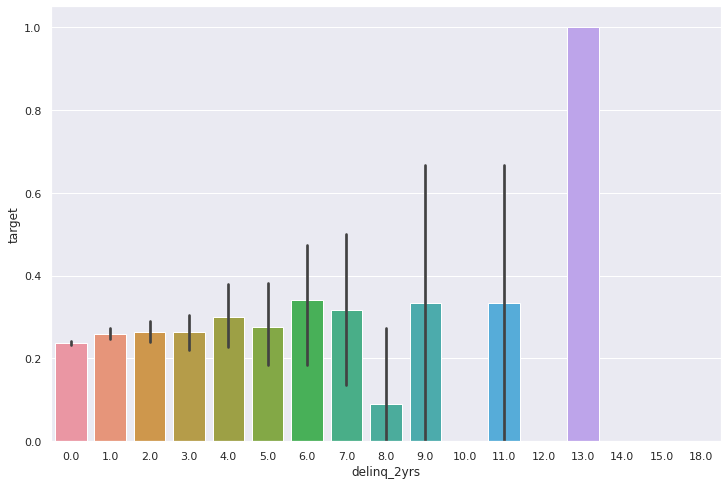

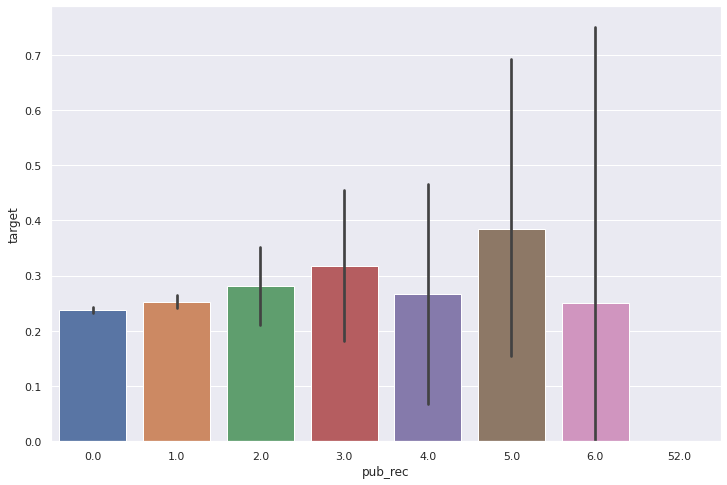

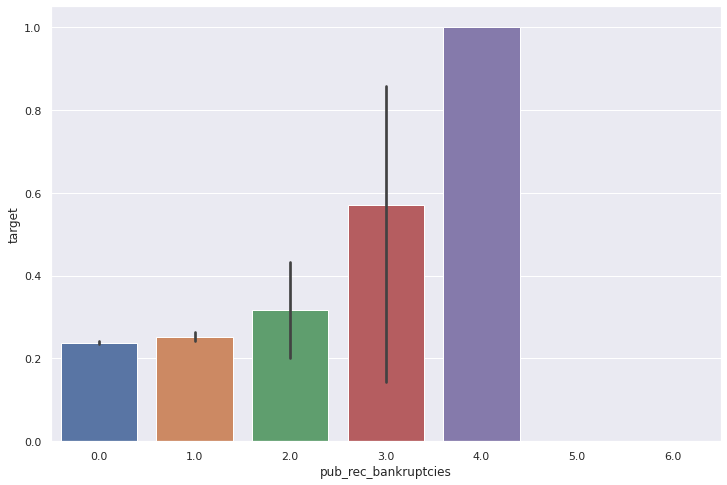

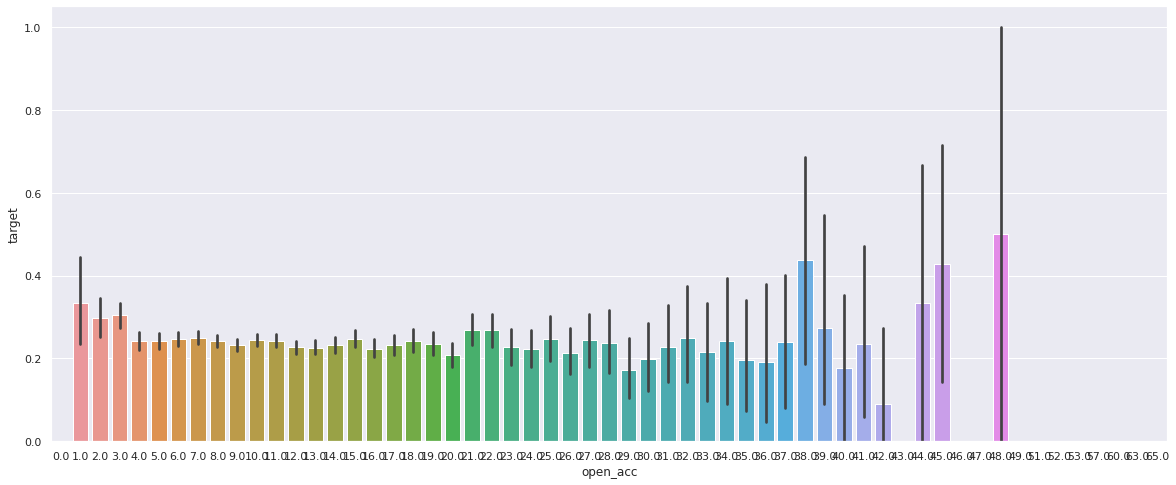

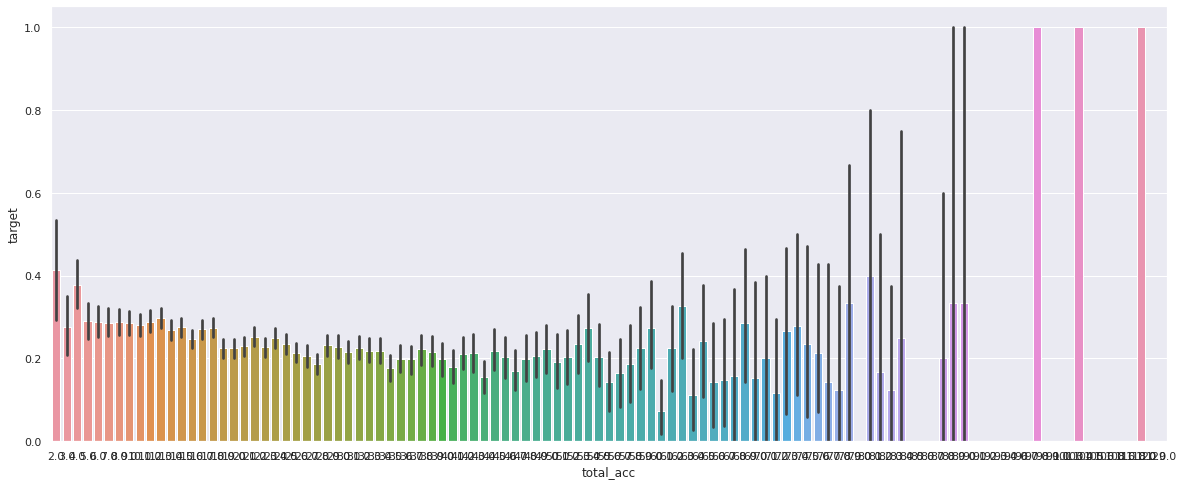

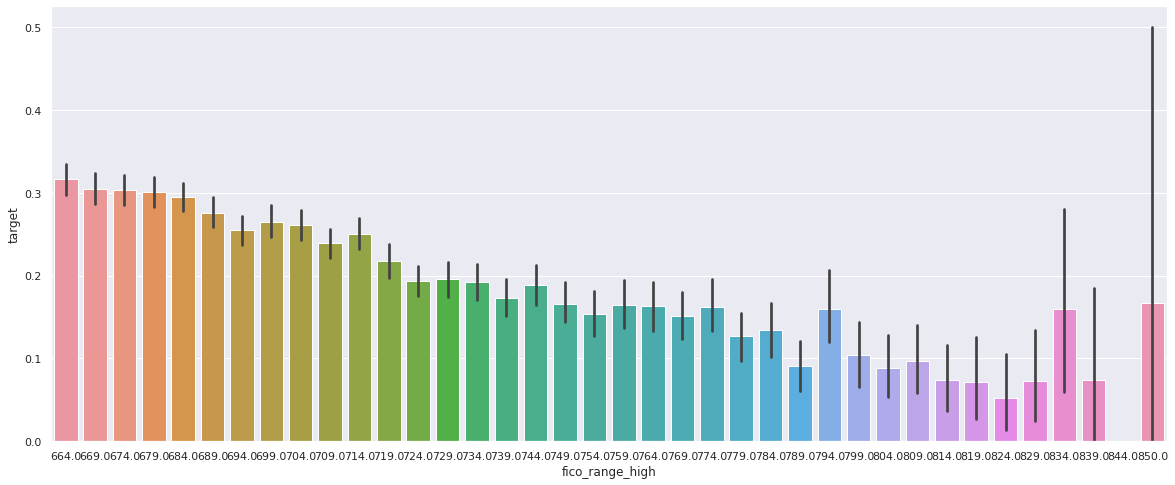

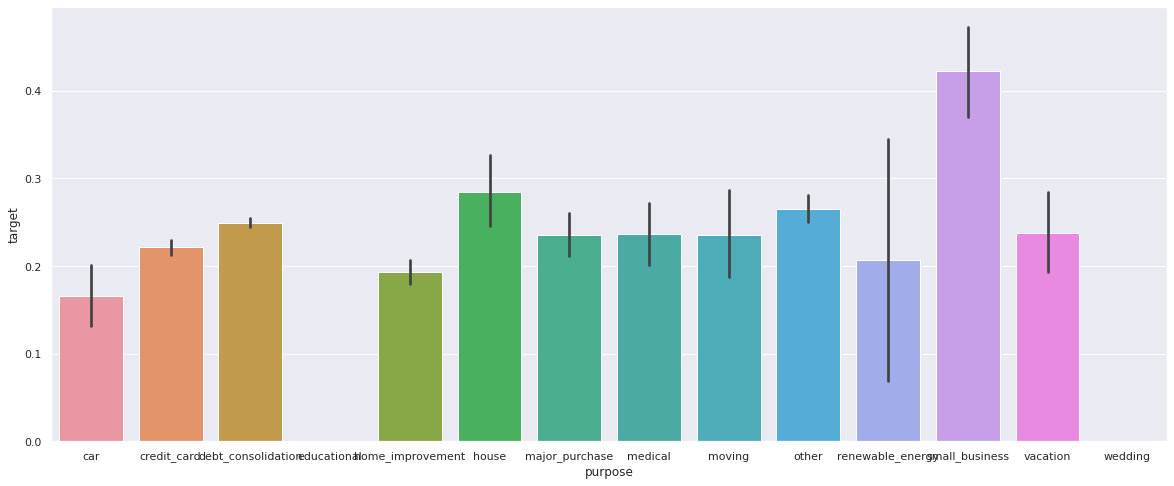

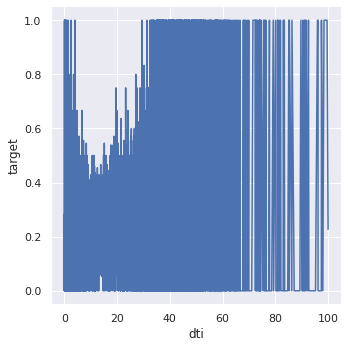

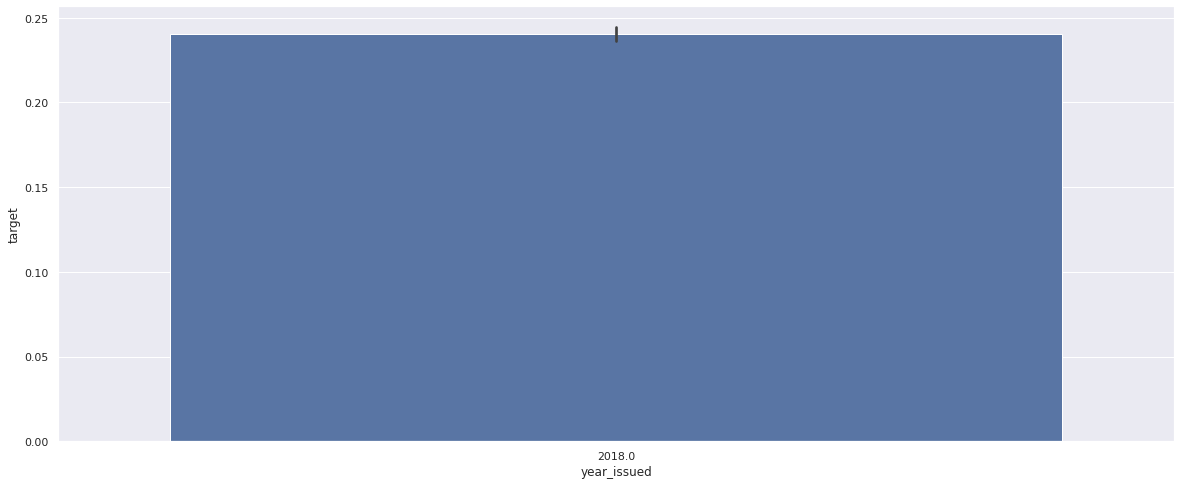

In [297]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

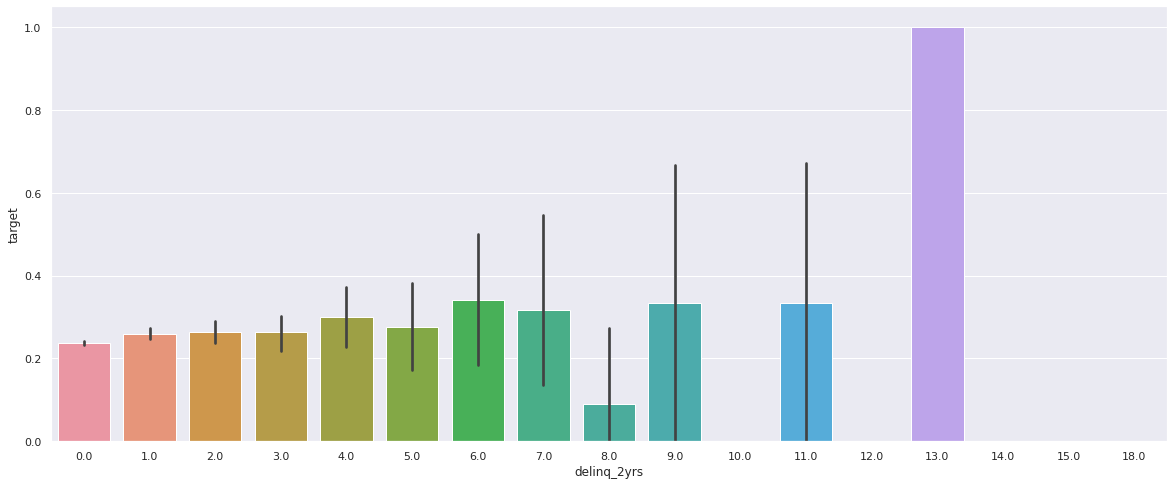

In [298]:
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()

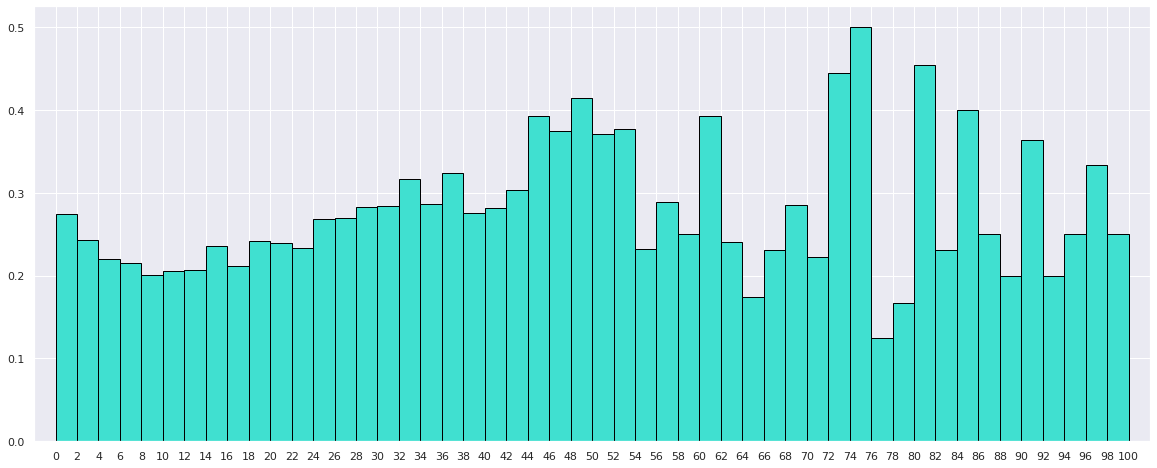

In [299]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### Train-test split, missing values

In [300]:
display(df.count())

loan_amnt                         39685
funded_amnt                       39685
funded_amnt_inv                   39685
term                              39685
int_rate                          39685
installment                       39685
purpose                           39685
title                             39685
initial_list_status               39685
application_type                  39685
grade                             39685
sub_grade                         39685
fico_range_high                   39685
emp_title                         35520
emp_length                        36199
home_ownership                    39685
annual_inc                        39685
zip_code                          39685
addr_state                        39685
dti                               39563
verification_status               39685
mo_sin_rcnt_tl                    39685
mths_since_last_delinq            39685
mths_since_last_major_derog       39685
mths_since_last_record            39685


In [301]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(35717, 77)

(3968, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,15000.0,15000.0,15000.0,36.0,10.47,487.329987,credit_card,Credit card refinancing,w,Individual,B,B2,679.0,Operator,4.0,RENT,110000.0,360,AL,16.680000,Source Verified,4.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,1.0,3.0,3.0,13.0,10.0,0.0,25.0,4460.0,57977.0,16823.0,54.8,4856.0,4.0,6.0,10.0,30700.0,0.0,0.0,0.0,0.0,0.0,57977.0,416.0,0.0,33.299999,100.0,2.0,1.0,0.0,0.0,0.0,0.0,2018.0,7,2018,10.412260,0.0,1.0,0.136364,0.053163,0,0.152936,0.040545,0.527064,0.527064,0.279091,0,0.520000,0
1,25000.0,25000.0,25000.0,60.0,20.89,674.789978,debt_consolidation,Debt consolidation,w,Individual,D,D4,669.0,ASSET/MAIL SERVICES MANAGER,10.0,RENT,58000.0,300,GA,31.469999,Not Verified,10.0,1200.0,71.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,3.0,22.0,5.0,2.0,54.0,9673.0,212825.0,27201.0,41.0,4433.0,10.0,20.0,20.0,66211.0,0.0,0.0,0.0,0.0,0.0,212825.0,0.0,0.0,44.400002,98.0,3.0,0.0,0.0,0.0,0.0,0.0,2018.0,11,2018,12.917445,0.0,0.0,0.431034,0.139612,0,0.468983,0.166776,3.669397,3.669397,1.141569,0,0.407407,0
2,10000.0,10000.0,10000.0,60.0,6.08,193.710007,credit_card,Credit card refinancing,w,Individual,A,A2,684.0,Certified Pharmacy Technician,2.0,RENT,38000.0,801,CO,19.080000,Not Verified,35.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,10.0,4429.0,17716.0,12911.0,56.1,8313.0,35.0,3.0,4.0,23000.0,0.0,0.0,0.0,0.0,0.0,17716.0,154.0,0.0,50.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,2,2018,13.755245,0.0,0.0,0.263158,0.061172,0,0.339763,0.116553,0.466211,0.466211,0.605263,0,0.500000,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,10000.0,10000.0,10000.0,36.0,20.39,373.630005,debt_consolidation,Debt consolidation,w,Individual,D,D4,674.0,Banker,2.0,RENT,46000.0,917,CA,4.07,Not Verified,16.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,3276.0,9828.0,9828.0,92.7,772.0,16.0,3.0,3.0,10600.0,0.0,0.0,0.0,0.0,0.0,9828.0,0.0,0.0,100.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,4,2018,3.162283,0.0,1.0,0.217391,0.097469,0,0.213652,0.071217,0.213652,0.213652,0.230435,0,1.000000,0
1,9000.0,9000.0,9000.0,36.0,10.08,290.750000,debt_consolidation,Debt consolidation,w,Individual,B,B1,699.0,Teacher,10.0,RENT,82000.0,300,GA,10.27,Source Verified,17.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0,17.0,3209.0,19255.0,15763.0,71.0,3313.0,18.0,4.0,5.0,22200.0,0.0,0.0,0.0,0.0,0.0,19255.0,0.0,0.0,50.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,8,2018,15.252880,0.0,0.0,0.109756,0.042549,0,0.192232,0.039134,0.234817,0.234817,0.270732,0,0.352941,0
2,17000.0,17000.0,17000.0,36.0,11.05,556.969971,debt_consolidation,Debt consolidation,f,Individual,B,B4,704.0,Registered Nurse,4.0,MORTGAGE,95000.0,850,AZ,13.78,Source Verified,2.0,21.0,1200.0,1200.0,34.0,34.0,3.0,0.0,1.0,2.0,18.0,6.0,2.0,42.0,15972.0,271531.0,8368.0,19.9,12154.0,2.0,8.0,14.0,42000.0,1.0,0.0,0.0,0.0,0.0,46802.0,103.0,0.0,0.0,95.199997,2.0,0.0,0.0,0.0,0.0,0.0,2018.0,5,2018,23.083294,0.0,0.0,0.178947,0.070354,0,0.088084,0.168126,2.858221,0.492653,0.442105,0,0.428571,0


loan_amnt                         35717
funded_amnt                       35717
funded_amnt_inv                   35717
term                              35717
int_rate                          35717
installment                       35717
purpose                           35717
title                             35717
initial_list_status               35717
application_type                  35717
grade                             35717
sub_grade                         35717
fico_range_high                   35717
emp_title                         35717
emp_length                        35717
home_ownership                    35717
annual_inc                        35717
zip_code                          35717
addr_state                        35717
dti                               35717
verification_status               35717
mo_sin_rcnt_tl                    35717
mths_since_last_delinq            35717
mths_since_last_major_derog       35717
mths_since_last_record            35717


loan_amnt                         3968
funded_amnt                       3968
funded_amnt_inv                   3968
term                              3968
int_rate                          3968
installment                       3968
purpose                           3968
title                             3968
initial_list_status               3968
application_type                  3968
grade                             3968
sub_grade                         3968
fico_range_high                   3968
emp_title                         3968
emp_length                        3968
home_ownership                    3968
annual_inc                        3968
zip_code                          3968
addr_state                        3968
dti                               3968
verification_status               3968
mo_sin_rcnt_tl                    3968
mths_since_last_delinq            3968
mths_since_last_major_derog       3968
mths_since_last_record            3968
mths_since_recent_bc_dlq 

### Categorical features encoding

In [302]:
# TE for categorical features

test00 = test.copy()
time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

26.980220079421997

1.1814544200897217

(35717, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,grade,fico_range_high,emp_length,home_ownership,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,15000.0,15000.0,15000.0,36.0,10.47,487.329987,w,Individual,B,679.0,4.0,RENT,110000.0,16.680000,Source Verified,4.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,1.0,3.0,3.0,13.0,10.0,0.0,25.0,4460.0,57977.0,16823.0,54.8,4856.0,4.0,6.0,10.0,30700.0,0.0,0.0,0.0,0.0,0.0,57977.0,416.0,0.0,33.299999,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2018.0,7,2018,10.412260,0.0,1.0,0.136364,0.053163,0,0.152936,0.040545,0.527064,0.527064,0.279091,0,0.520000,0,0.178844,0.337513,0.215259,0.215259,0.176510,0.251243
1,25000.0,25000.0,25000.0,60.0,20.89,674.789978,w,Individual,D,669.0,10.0,RENT,58000.0,31.469999,Not Verified,10.0,1200.0,71.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,3.0,22.0,5.0,2.0,54.0,9673.0,212825.0,27201.0,41.0,4433.0,10.0,20.0,20.0,66211.0,0.0,0.0,0.0,0.0,0.0,212825.0,0.0,0.0,44.400002,98.000000,3.0,0.0,0.0,0.0,0.0,0.0,2018.0,11,2018,12.917445,0.0,0.0,0.431034,0.139612,0,0.468983,0.166776,3.669397,3.669397,1.141569,0,0.407407,0,0.384355,0.241274,0.251281,0.251281,0.233385,0.247961
2,10000.0,10000.0,10000.0,60.0,6.08,193.710007,w,Individual,A,684.0,2.0,RENT,38000.0,19.080000,Not Verified,35.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,10.0,4429.0,17716.0,12911.0,56.1,8313.0,35.0,3.0,4.0,23000.0,0.0,0.0,0.0,0.0,0.0,17716.0,154.0,0.0,50.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,2,2018,13.755245,0.0,0.0,0.263158,0.061172,0,0.339763,0.116553,0.466211,0.466211,0.605263,0,0.500000,0,0.071729,0.219340,0.215259,0.215259,0.217203,0.185691
3,7500.0,7500.0,7500.0,36.0,19.42,276.519989,w,Individual,D,679.0,0.0,RENT,28000.0,17.660000,Verified,4.0,1200.0,1200.0,1200.0,1200.0,1200.0,5.0,0.0,0.0,1.0,11.0,10.0,0.0,15.0,761.0,8372.0,8372.0,44.5,3408.0,4.0,9.0,11.0,18800.0,0.0,0.0,0.0,0.0,0.0,8372.0,0.0,0.0,66.699997,100.000000,5.0,0.0,0.0,0.0,0.0,0.0,2018.0,6,2018,12.085122,0.0,0.0,0.267857,0.118509,0,0.299000,0.027179,0.299000,0.299000,0.671429,0,0.733333,0,0.370920,0.337070,0.271655,0.271655,0.268373,0.291706
4,6000.0,6000.0,6000.0,36.0,16.14,211.360001,w,Individual,C,709.0,2.0,MORTGAGE,30000.0,28.799999,Source Verified,2.0,81.0,1200.0,1200.0,81.0,81.0,3.0,1.0,1.0,4.0,10.0,6.0,1.0,32.0,5895.0,58950.0,876.0,7.5,8640.0,5.0,3.0,6.0,11700.0,0.0,0.0,0.0,0.0,0.0,58747.0,1418.0,0.0,0.000000,96.900002,1.0,1.0,0.0,0.0,0.0,0.0,2018.0,8,2018,11.748359,0.0,1.0,0.200000,0.084544,0,0.029200,0.196500,1.965000,1.958233,0.390000,0,0.312500,0,0.321895,0.241274,0.251281,0.251281,0.216334,0.236697


loan_amnt                         35717
funded_amnt                       35717
funded_amnt_inv                   35717
term                              35717
int_rate                          35717
installment                       35717
initial_list_status               35717
application_type                  35717
grade                             35717
fico_range_high                   35717
emp_length                        35717
home_ownership                    35717
annual_inc                        35717
dti                               35717
verification_status               35717
mo_sin_rcnt_tl                    35717
mths_since_last_delinq            35717
mths_since_last_major_derog       35717
mths_since_last_record            35717
mths_since_recent_bc_dlq          35717
mths_since_recent_revol_delinq    35717
num_tl_op_past_12m                35717
inq_last_6mths                    35717
inq_fi                            35717
inq_last_12m                      35717


In [303]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,grade,fico_range_high,emp_length,home_ownership,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,10000.0,10000.0,10000.0,36.0,20.39,373.630005,w,Individual,D,674.0,2.0,RENT,46000.0,4.070000,Not Verified,16.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,3276.0,9828.0,9828.0,92.7,772.0,16.0,3.0,3.0,10600.0,0.0,0.0,0.0,0.0,0.0,9828.0,0.0,0.0,100.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,4,2018,3.162283,0.0,0.217391,0.097469,0,0.213652,0.071217,0.213652,0.213652,0.230435,0,1.000000,0,0.388580,0.289393,0.249845,0.249845,0.209529,0.254359
1,9000.0,9000.0,9000.0,36.0,10.08,290.750000,w,Individual,B,699.0,10.0,RENT,82000.0,10.270000,Source Verified,17.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0,17.0,3209.0,19255.0,15763.0,71.0,3313.0,18.0,4.0,5.0,22200.0,0.0,0.0,0.0,0.0,0.0,19255.0,0.0,0.0,50.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,8,2018,15.252880,0.0,0.109756,0.042549,0,0.192232,0.039134,0.234817,0.234817,0.270732,0,0.352941,0,0.151404,0.216949,0.249845,0.249845,0.229463,0.241240
2,17000.0,17000.0,17000.0,36.0,11.05,556.969971,f,Individual,B,704.0,4.0,MORTGAGE,95000.0,13.780000,Source Verified,2.0,21.0,1200.0,1200.0,34.0,34.0,3.0,0.0,1.0,2.0,18.0,6.0,2.0,42.0,15972.0,271531.0,8368.0,19.9,12154.0,2.0,8.0,14.0,42000.0,1.0,0.0,0.0,0.0,0.0,46802.0,103.0,0.0,0.0,95.199997,2.0,0.0,0.0,0.0,0.0,0.0,2018.0,5,2018,23.083294,0.0,0.178947,0.070354,0,0.088084,0.168126,2.858221,0.492653,0.442105,0,0.428571,0,0.215921,0.192185,0.249845,0.249845,0.192442,0.213008
3,13325.0,13325.0,13325.0,36.0,27.27,545.929993,f,Joint App,E,684.0,0.0,RENT,14208.0,33.450001,Verified,18.0,7.0,1200.0,1200.0,7.0,7.0,0.0,2.0,0.0,2.0,5.0,5.0,0.0,13.0,2383.0,11915.0,11915.0,82.7,2485.0,18.0,5.0,5.0,14400.0,1.0,0.0,0.0,0.0,0.0,11915.0,0.0,0.0,80.0,92.300003,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,9,2018,17.831988,0.0,0.937852,0.461090,1,0.838612,0.167722,0.838612,0.838612,1.013514,0,0.384615,0,0.425615,0.332496,0.216587,0.216587,0.285252,0.228632
4,40000.0,40000.0,40000.0,60.0,14.07,932.190002,w,Individual,C,714.0,7.0,MORTGAGE,160000.0,6.920000,Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,1.0,3.0,6.0,5.0,5.0,2.0,20.0,88488.0,442442.0,26152.0,52.3,15848.0,3.0,2.0,2.0,50000.0,0.0,0.0,0.0,0.0,0.0,55959.0,0.0,0.0,0.0,100.000000,1.0,2.0,0.0,0.0,0.0,0.0,2018.0,5,2018,10.497135,0.0,0.250000,0.069914,0,0.163450,0.553050,2.765263,0.349744,0.312500,0,0.250000,0,0.296395,0.239606,0.216587,0.216587,0.276531,0.243362


Number of features before transaformation:  (35717, 76)
time to do feature proprocessing:  1.4679388999938965
Number of features after transaformation:  (35717, 89)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_f,cat__initial_list_status_w,cat__application_type_Individual,cat__application_type_Joint App,cat__grade_A,cat__grade_B,cat__grade_C,cat__grade_D,cat__grade_E,cat__grade_F,cat__grade_G,cat__home_ownership_MORTGAGE,cat__home_ownership_OTHER,cat__home_ownership_OWN,cat__home_ownership_RENT,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__fico_range_high,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__mo_sin_rcnt_tl,remainder__mths_since_last_delinq,remainder__mths_since_last_major_derog,remainder__mths_since_last_record,remainder__mths_since_recent_bc_dlq,remainder__mths_since_recent_revol_delinq,remainder__num_tl_op_past_12m,remainder__inq_last_6mths,remainder__inq_fi,remainder__inq_last_12m,remainder__open_acc,remainder__acc_open_past_24mths,remainder__mort_acc,remainder__total_acc,remainder__avg_cur_bal,remainder__tot_cur_bal,remainder__revol_bal,remainder__revol_util,remainder__bc_open_to_buy,remainder__mo_sin_rcnt_rev_tl_op,remainder__num_actv_rev_tl,remainder__num_op_rev_tl,remainder__total_rev_hi_lim,remainder__delinq_2yrs,remainder__acc_now_delinq,remainder__delinq_amnt,remainder__pub_rec,remainder__pub_rec_bankruptcies,remainder__total_bal_ex_mort,remainder__tot_coll_amt,remainder__tax_liens,remainder__percent_bc_gt_75,remainder__pct_tl_nvr_dlq,remainder__open_rv_12m,remainder__open_il_12m,remainder__num_tl_90g_dpd_24m,remainder__num_tl_30dpd,remainder__num_tl_120dpd_2m,remainder__num_accts_ever_120_pd,remainder__year_issued,remainder__month_issued,remainder__year_earliest,remainder__years_borrowing,remainder__pub_rec_pa,remainder__lti,remainder__iti,remainder__joint,remainder__revol_balance_income,remainder__avg_cur_bal_inc,remainder__tot_cur_bal_inc,remainder__total_bal_ex_mort_inc,remainder__total_rev_inc,remainder__low_fico,remainder__open_cl_ratio,remainder__was_bankrupt,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15000.0,15000.0,15000.0,36.0,10.47,487.329987,679.0,4.0,110000.0,16.680000,4.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,1.0,3.0,3.0,13.0,10.0,0.0,25.0,4460.0,57977.0,16823.0,54.8,4856.0,4.0,6.0,10.0,30700.0,0.0,0.0,0.0,0.0,0.0,57977.0,416.0,0.0,33.299999,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2018.0,7.0,2018.0,10.412260,0.0,0.136364,0.053163,0.0,0.152936,0.040545,0.527064,0.527064,0.279091,0.0,0.520000,0.0,0.178844,0.337513,0.215259,0.215259,0.176510,0.251243
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25000.0,25000.0,25000.0,60.0,20.89,674.789978,669.0,10.0,58000.0,31.469999,10.0,1200.0,71.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,3.0,22.0,5.0,2.0,54.0,9673.0,212825.0,27201.0,41.0,4433.0,10.0,20.0,20.0,66211.0,0.0,0.0,0.0,0.0,0.0,212825.0,0.0,0.0,44.400002,98.000000,3.0,0.0,0.0,0.0,0.0,0.0,2018.0,11.0,2018.0,12.917445,0.0,0.431034,0.139612,0.0,0.468983,0.166776,3.669397,3.669397,1.141569,0.0,0.407407,0.0,0.384355,0.241274,0.251281,0.251281,0.233385,0.247961
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10000.0,10000.0,10000.0,60.0,6.08,193.710007,684.0,2.0,38000.0,19.080000,35.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,10.0,4429.0,17716.0,12911.0,56.1,8313.0,35.0,3.0,4.0,23000.0,0.0,0.0,0.0,0.0,0.0,17716.0,154.0,0.0,50.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,2.0,2018.0,13.755245,0.0,0.263158,0.061172,0.0,0.339763,0.116553,0.466211,0.466211,0.605263,0.0,0.500000,0.0,0.071729,0.219340,0.215259,0.215259,0.217203,0.185691
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7500.0,7500.0,7500.0,36.0,19.42,276.519989,679.0,0.0,28000.0,17.660000,4.0,1200.0,1200.0,1200.0,12

### Modeling

'Train Accuracy: '

0.8877845283758434

'F1 score: '

0.708041958041958

'ROCAUC: '

0.7782377148527698

'PRAUC: '

0.8829453058143661

'R20P: '

0.9930354033662218

'Test Accuracy: '

0.7613407258064516

'F1 score: '

0.33262861169837915

'ROCAUC: '

0.5865398542389806

'PRAUC: '

0.4468499727053504

'R20P: '

0.5644699140401146

1.378359317779541

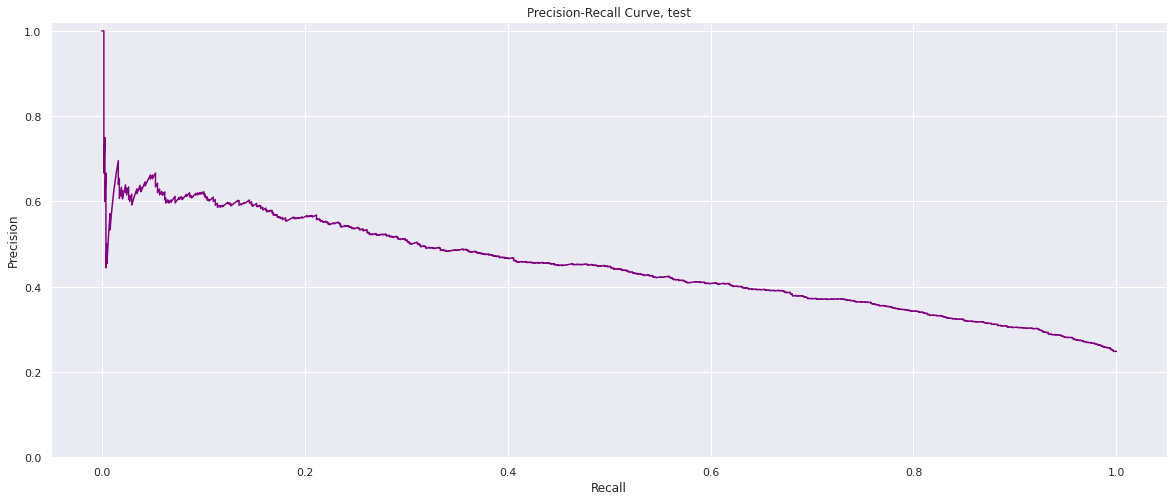

In [304]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

[I 2022-08-13 04:23:53,138] A new study created in memory with name: no-name-4b5e881b-62fe-4f5a-ad57-5f72171b9ffe
[I 2022-08-13 04:23:56,801] Trial 0 finished with value: 0.5636280891467376 and parameters: {'n_estimators': 436, 'max_depth': 5, 'learning_rate': 0.04396467925939543, 'colsample_bytree': 0.2628199403638958, 'subsample': 0.5266310018748893, 'alpha': 0.7435477024667437, 'lambda': 0.477753282385151, 'gamma': 0.0010084023581351284, 'min_child_weight': 3.786945792819299}. Best is trial 0 with value: 0.5636280891467376.
[I 2022-08-13 04:24:00,494] Trial 1 finished with value: 0.554771760978929 and parameters: {'n_estimators': 466, 'max_depth': 5, 'learning_rate': 0.023691361244068912, 'colsample_bytree': 0.23794702303322812, 'subsample': 0.6753853816288681, 'alpha': 3.193626714749565, 'lambda': 118.97001931546343, 'gamma': 1.748348611173985, 'min_child_weight': 8.494143811006117}. Best is trial 0 with value: 0.5636280891467376.
[I 2022-08-13 04:24:02,482] Trial 2 finished with v

Total time for hypermarameter optimization  101.12662172317505
        n_estimators : 170
           max_depth : 4
       learning_rate : 0.30950804379062935
    colsample_bytree : 0.43790812862436684
           subsample : 0.5035282342746219
               alpha : 0.6276625241289169
              lambda : 7.114763217626359
               gamma : 0.028847350994825008
    min_child_weight : 2.7558959256088853
best objective value : 0.5786104230196905


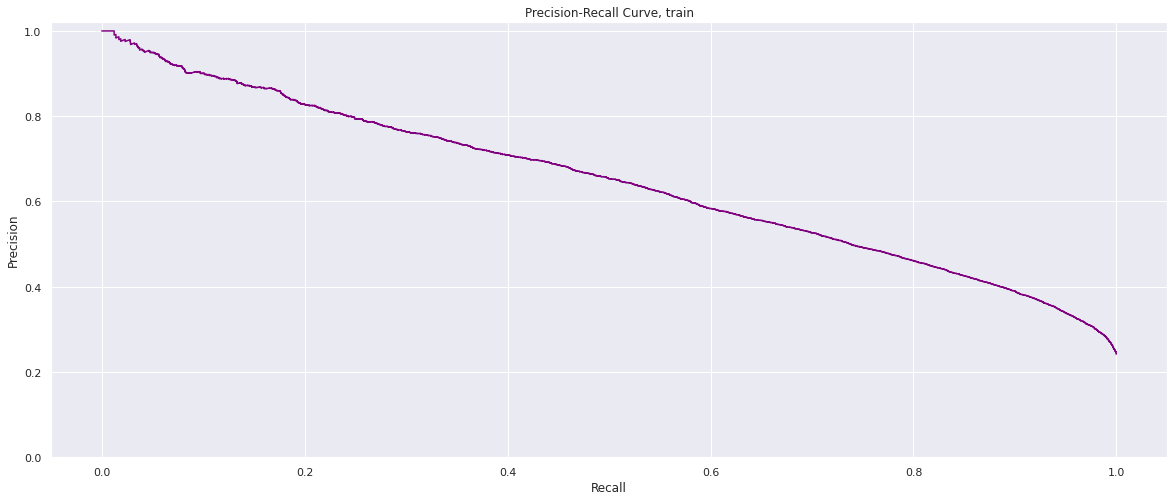

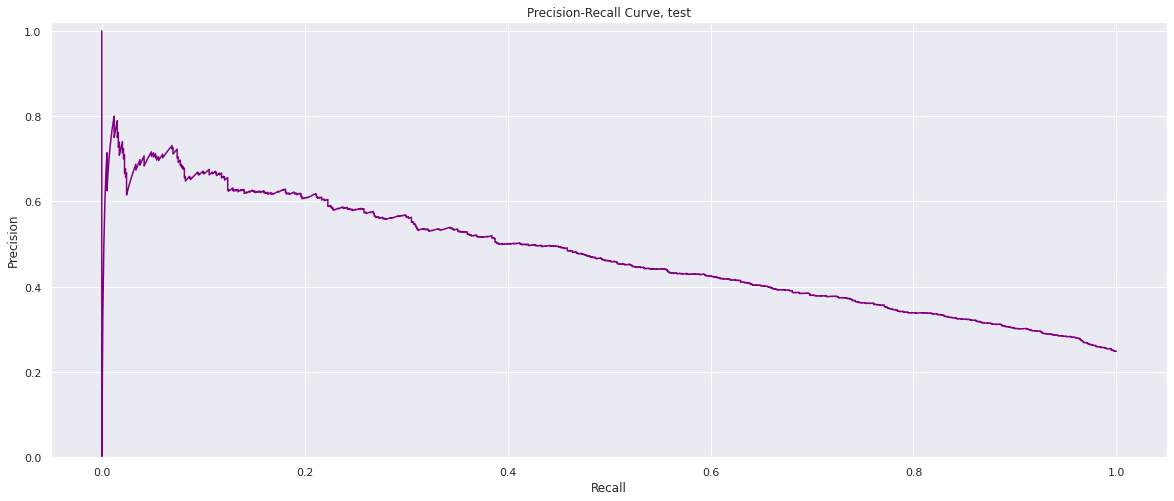

'Train Accuracy: '

0.8141781224626928

'F1 score: '

0.4718707726585501

'ROCAUC: '

0.654009578554397

'PRAUC: '

0.6463767479002763

'R20P: '

0.8273694390715667

'Test Accuracy: '

0.7689012096774194

'F1 score: '

0.3645183645183645

'ROCAUC: '

0.6007758357743277

'PRAUC: '

0.47226104605062136

'R20P: '

0.60625

103.31161570549011

In [305]:
### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=2):

    cv_regularizer=0.025
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.4),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

In [306]:
results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
fi = fi.sort_values('FI', ascending = False)

display(fi[:30])

,col,FI
21,remainder__term,0.007510
84,remainder__emp_title_encoded,0.006653
27,remainder__dti,0.005796
79,remainder__total_rev_inc,0.004486
81,remainder__open_cl_ratio,0.004284
87,remainder__zip_code_encoded,0.003982
22,remainder__int_rate,0.003730
17,cat__home_ownership_RENT,0.003377
83,remainder__sub_grade_encoded,0.003125
45,remainder__revol_util,0.003075


,col_name,feature_importance_vals
22,remainder__int_rate,0.166535
7,cat__grade_A,0.143823
21,remainder__term,0.143239
27,remainder__dti,0.140440
83,remainder__sub_grade_encoded,0.132571
48,remainder__num_actv_rev_tl,0.116325
84,remainder__emp_title_encoded,0.112547
79,remainder__total_rev_inc,0.104195
17,cat__home_ownership_RENT,0.102167
81,remainder__open_cl_ratio,0.097111


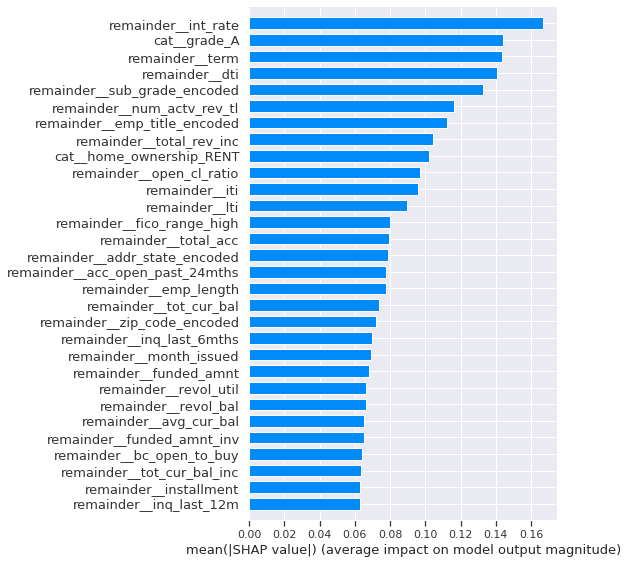

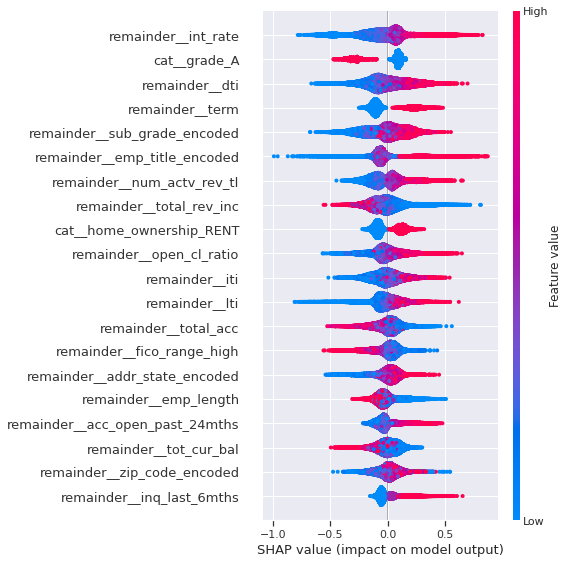

In [307]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
display(feature_importance[:30])

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)

shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [308]:
# error analysis
y_pred = optuna_xgb.predict_proba(X_test)[:, 1]
error_df = test0.copy()
error_df['truth'] = y_test
error_df['pred'] = y_pred
error_df['error'] = error_df.pred - error_df.truth
error_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,grade,fico_range_high,emp_length,home_ownership,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,truth,pred,error
0,10000.0,10000.0,10000.0,36.0,20.39,373.630005,w,Individual,D,674.0,2.0,RENT,46000.0,4.070000,Not Verified,16.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,3276.0,9828.0,9828.0,92.7,772.0,16.0,3.0,3.0,10600.0,0.0,0.0,0.0,0.0,0.0,9828.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,4,2018,3.162283,0.0,1.0,0.217391,0.097469,0,0.213652,0.071217,0.213652,0.213652,0.230435,0,1.000000,0,0.388580,0.289393,0.249845,0.249845,0.209529,0.254359,1.0,0.270302,-0.729698
1,9000.0,9000.0,9000.0,36.0,10.08,290.750000,w,Individual,B,699.0,10.0,RENT,82000.0,10.270000,Source Verified,17.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,6.0,3.0,0.0,17.0,3209.0,19255.0,15763.0,71.0,3313.0,18.0,4.0,5.0,22200.0,0.0,0.0,0.0,0.0,0.0,19255.0,0.0,0.0,50.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,8,2018,15.252880,0.0,0.0,0.109756,0.042549,0,0.192232,0.039134,0.234817,0.234817,0.270732,0,0.352941,0,0.151404,0.216949,0.249845,0.249845,0.229463,0.241240,0.0,0.084292,0.084292
2,17000.0,17000.0,17000.0,36.0,11.05,556.969971,f,Individual,B,704.0,4.0,MORTGAGE,95000.0,13.780000,Source Verified,2.0,21.0,1200.0,1200.0,34.0,34.0,3.0,0.0,1.0,2.0,18.0,6.0,2.0,42.0,15972.0,271531.0,8368.0,19.9,12154.0,2.0,8.0,14.0,42000.0,1.0,0.0,0.0,0.0,0.0,46802.0,103.0,0.0,0.000000,95.199997,2.0,0.0,0.0,0.0,0.0,0.0,2018.0,5,2018,23.083294,0.0,0.0,0.178947,0.070354,0,0.088084,0.168126,2.858221,0.492653,0.442105,0,0.428571,0,0.215921,0.192185,0.249845,0.249845,0.192442,0.213008,0.0,0.053456,0.053456
3,13325.0,13325.0,13325.0,36.0,27.27,545.929993,f,Joint App,E,684.0,0.0,RENT,14208.0,33.450001,Verified,18.0,7.0,1200.0,1200.0,7.0,7.0,0.0,2.0,0.0,2.0,5.0,5.0,0.0,13.0,2383.0,11915.0,11915.0,82.7,2485.0,18.0,5.0,5.0,14400.0,1.0,0.0,0.0,0.0,0.0,11915.0,0.0,0.0,80.000000,92.300003,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,9,2018,17.831988,0.0,0.0,0.937852,0.461090,1,0.838612,0.167722,0.838612,0.838612,1.013514,0,0.384615,0,0.425615,0.332496,0.216587,0.216587,0.285252,0.228632,0.0,0.780446,0.780446
4,40000.0,40000.0,40000.0,60.0,14.07,932.190002,w,Individual,C,714.0,7.0,MORTGAGE,160000.0,6.920000,Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,1.0,3.0,6.0,5.0,5.0,2.0,20.0,88488.0,442442.0,26152.0,52.3,15848.0,3.0,2.0,2.0,50000.0,0.0,0.0,0.0,0.0,0.0,55959.0,0.0,0.0,0.000000,100.000000,1.0,2.0,0.0,0.0,0.0,0.0,2018.0,5,2018,10.497135,0.0,1.0,0.250000,0.069914,0,0.163450,0.553050,2.765263,0.349744,0.312500,0,0.250000,0,0.296395,0.239606,0.216587,0.216587,0.276531,0.243362,1.0,0.520460,-0.479540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3963,20000.0,20000.0,20000.0,36.0,7.9

In [309]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error>0.8])

,truth,pred
count,3968.000000,3968.000000
mean,0.247732,0.245571
std,0.431750,0.186529
min,0.000000,0.001119
25%,0.000000,0.095933
50%,0.000000,0.195368
75%,0.000000,0.357638
max,1.000000,0.916089


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,grade,fico_range_high,emp_length,home_ownership,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,truth,pred,error
412,35000.0,35000.0,35000.0,60.0,18.94,906.770020,f,Individual,D,684.0,3.0,OWN,142000.0,34.770000,Not Verified,1.0,49.0,1200.0,46.0,1200.0,1200.0,3.0,0.0,0.0,0.0,16.0,7.0,0.0,39.0,9595.0,153515.0,14122.0,77.6,969.0,1.0,9.0,9.0,18200.0,0.0,0.0,0.0,1.0,1.0,153515.0,2409.0,0.0,25.0,97.099998,2.0,1.0,0.0,0.0,0.0,0.0,2018.0,12,2018,13.418482,0.074524,0.0,0.246479,0.076628,0,0.099451,0.067570,1.081092,1.081092,0.128169,0,0.410256,1,0.353083,0.239606,0.249845,0.249845,0.287942,0.254359,0.0,0.812814,0.812814
1660,31500.0,31500.0,31500.0,36.0,26.31,1274.369995,w,Joint App,E,664.0,0.0,MORTGAGE,25000.0,59.290001,Verified,2.0,38.0,38.0,77.0,1200.0,1200.0,3.0,0.0,6.0,13.0,9.0,5.0,3.0,16.0,21690.0,173522.0,2990.0,24.9,NaN,8.0,3.0,5.0,12000.0,0.0,0.0,0.0,1.0,1.0,56788.0,1241.0,0.0,NaN,75.000000,1.0,2.0,0.0,0.0,0.0,3.0,2018.0,11,2018,36.586651,0.027332,0.0,1.260000,0.611698,1,0.119600,0.867600,6.940880,2.271520,0.480000,0,0.562500,1,0.470440,0.332496,0.249845,0.249845,0.256112,0.267013,0.0,0.916089,0.916089
1991,18125.0,18125.0,18125.0,60.0,28.72,572.239990,w,Individual,F,704.0,1.0,RENT,50000.0,38.639999,Source Verified,12.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,6.0,12.0,1.0,0.0,16.0,10208.0,122498.0,27607.0,89.1,793.0,41.0,2.0,4.0,31000.0,0.0,0.0,0.0,0.0,0.0,122498.0,0.0,0.0,100.0,100.000000,0.0,1.0,0.0,0.0,0.0,0.0,2018.0,2,2018,13.418482,0.000000,0.0,0.362500,0.137338,0,0.552140,0.204160,2.449960,2.449960,0.620000,0,0.750000,0,0.505127,0.239606,0.249845,0.249845,0.254773,0.229079,0.0,0.805923,0.805923
2097,35000.0,35000.0,35000.0,60.0,22.35,973.640015,w,Individual,D,669.0,10.0,RENT,73000.0,13.640000,Verified,2.0,1200.0,1200.0,84.0,1200.0,1200.0,2.0,0.0,0.0,2.0,10.0,8.0,0.0,20.0,2662.0,26616.0,9795.0,49.0,89.0,16.0,5.0,9.0,20000.0,0.0,0.0,0.0,1.0,1.0,26616.0,0.0,0.0,100.0,100.000000,0.0,2.0,0.0,0.0,0.0,0.0,2018.0,11,2018,11.918109,0.083906,0.0,0.479452,0.160050,0,0.134178,0.036466,0.364603,0.364603,0.273973,0,0.500000,1,0.403140,0.239606,0.249845,0.249845,0.265506,0.281614,0.0,0.821192,0.821192
2495,15600.0,15600.0,15600.0,36.0,18.94,571.369995,w,Individual,D,669.0,4.0,RENT,45000.0,19.629999,Verified,3.0,30.0,30.0,1200.0,1200.0,1200.0,3.0,1.0,4.0,8.0,4.0,3.0,0.0,6.0,1389.0,5555.0,29.0,2.2,1271.0,3.0,2.0,3.0,1300.0,0.0,0.0,0.0,0.0,0.0,5555.0,0.0,0.0,0.0,83.300003,3.0,0.0,0.0,0.0,0.0,1.0,2018.0,8,2018,10.666886,0.000000,0.0,0.346667,0.152365,0,0.000644,0.030867,0.123444,0.123444,0.028889,0,0.666667,0,0.353083,0.290807,0.249845,0.249845,0.244182,0.288410,0.0,0.891510,0.891510
2705,35000.0,35000.0,35000.0,60.0,16.91,868.150024,w,Joint App,C,684.0,0.0,MORTGAGE,40000.0,26.459999,Not Verified,8.0,3.0,45.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,11.0,3.0,3.0,18.0,29660.0,326258.0,17643.0,66.6,7635.0,8.0,6.0,8.0,26500.0,1.0,0.0,0.0,0.0,0.0,26665.0,0.0,0.0,60.0,94.099998,1.0,0.0,0.0,0.0,0.0,1.0,2018.0,8,2018,25.166841,0.000000,0.0,0.87500

In [310]:
error_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,fico_range_high,emp_length,annual_inc,dti,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,truth,pred,error
count,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3.968000e+03,3968.000000,3968.000000,3920.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.0,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3920.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.0,3968.0,3968.000000,3968.0,3968.000000,3968.0,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.0,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000,3968.000000
mean,15525.498047,15525.498047,15521.824219,42.362903,13.118128,463.979492,710.394897,5.199597,77334.421875,18.605537,7.846270,677.291077,925.082886,1038.024170,968.520386,860.541321,2.293851,0.537802,1.260081,2.227571,11.500000,4.905746,1.405494,23.513609,13835.393555,1.433814e+05,14421.241211,40.627974,15221.642578,13.775454,5.103075,8.170615,36776.304688,0.224294,0.0,0.363659,0.153730,0.141381,49608.910156,219.907257,0.011845,29.973928,94.669777,1.353831,0.798135,0.059980,0.0,0.0,0.496472,2018.0,5.976058,2018.0,15.761519,0.011273,0.247732,0.246798,0.092650,0.127772,68.974747,80.210220,591.691956,197.090317,205.986267,0.0,0.535383,0.139365,0.238208,0.248710,0.239982,0.239988,0.240247,0.240590,0.247732,0.245571,-0.002161
std,10066.240234,10066.240234,10065.472656,10.594877,5.323097,294.633820,36.682625,3.917730,52792.398438,11.339685,8.641506,578.613403,491.543304,393.627686,463.704681,528.676819,2.051724,0.783355,1.605354,2.493425,6.006299,3.420631,1.758451,12.730726,16715.687500,1.564910e+05,18490.828125,25.051818,19336.121094,16.724407,3.337304,4.974335,33826.156250,0.746115,0.0,22.907648,0.398581,0.356327,48571.000000,1371.649536,0.157530,34.371468,8.791878,1.581435,1.013808,0.440491,0.0,0.0,1.388123,0.0,3.312964,0.0,7.670665,0.035071,0.431750,0.207465,0.099918,0.333878,1490.768799,2045.710571,12870.381836,3811.086182,3742.288574,0.0,0.189837,0.346371,0.110534,0.050782,0.027521,0.027524,0.051751,0.032553,0.431750,0.186529,0.404348
min,1000.000000,1000.000000,950.000000,36.000000,5.310000,30.750000,664.000000,0.000000,1.000000,0.000000,0.000000,2.000000,3.000000,7.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.600000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2018.0,1.000000,2018.0,3.077407,0.000000,0.000000,0.007407,0.002845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.027778,0.000000,0.063099,0.068091,0.1

In [311]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error<-0.95])

,truth,pred
count,3968.000000,3968.000000
mean,0.247732,0.245571
std,0.431750,0.186529
min,0.000000,0.001119
25%,0.000000,0.095933
50%,0.000000,0.195368
75%,0.000000,0.357638
max,1.000000,0.916089


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,grade,fico_range_high,emp_length,home_ownership,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,truth,pred,error
43,1000.0,1000.0,1000.0,36.0,9.43,32.009998,w,Joint App,B,764.0,10.0,MORTGAGE,135000.0,25.799999,Not Verified,8.0,18.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,2.0,1.0,13.0,6.0,3.0,28.0,20928.0,272060.0,15453.0,22.0,37685.0,20.0,5.0,8.0,70100.0,1.0,0.0,0.0,0.0,0.0,140634.0,0.0,0.0,25.000000,96.400002,0.0,1.0,0.0,0.0,0.0,0.0,2018.0,3,2018,30.497546,0.000000,1.0,0.007407,0.002845,1,0.114467,0.155022,2.015259,1.041733,0.519259,0,0.464286,0,0.151404,0.299092,0.249845,0.249845,0.243968,0.243362,1.0,0.033480,-0.966520
56,10000.0,10000.0,10000.0,36.0,6.71,307.450012,w,Individual,A,669.0,0.0,OWN,52000.0,7.340000,Source Verified,30.0,1200.0,1200.0,85.0,1200.0,1200.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,4698.0,9396.0,9396.0,48.4,10004.0,60.0,2.0,2.0,19400.0,0.0,0.0,0.0,1.0,1.0,9396.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,3,2018,11.496472,0.086983,1.0,0.192308,0.070950,0,0.180692,0.090346,0.180692,0.180692,0.373077,0,0.333333,1,0.091124,0.239606,0.216587,0.216587,0.239071,0.281614,1.0,0.049043,-0.950957
180,30000.0,30000.0,30000.0,36.0,6.11,914.159973,w,Individual,A,764.0,10.0,OWN,114400.0,9.050000,Source Verified,13.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,1.0,0.0,5.0,2.0,1.0,8.0,10434.0,52170.0,9555.0,47.3,7445.0,43.0,1.0,2.0,20200.0,0.0,0.0,0.0,0.0,0.0,19201.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,11,2018,7.252716,0.000000,1.0,0.262238,0.095891,0,0.083523,0.091206,0.456031,0.167841,0.176573,0,0.625000,0,0.063099,0.257185,0.249845,0.249845,0.274123,0.264225,1.0,0.029607,-0.970393
357,40000.0,40000.0,40000.0,36.0,10.08,1292.199951,w,Joint App,B,714.0,0.0,OWN,1.0,17.280001,Not Verified,2.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,1.0,0.0,1.0,14.0,4.0,0.0,28.0,4668.0,65347.0,39898.0,70.1,11049.0,2.0,5.0,10.0,56900.0,0.0,0.0,0.0,0.0,0.0,65347.0,0.0,0.0,33.299999,100.000000,2.0,0.0,0.0,0.0,0.0,0.0,2018.0,8,2018,10.833898,0.000000,1.0,1.500000,1.000000,1,39898.000000,4668.000000,65347.000000,65347.000000,56900.000000,0,0.500000,0,0.151404,0.332496,0.216587,0.216587,0.159474,0.201975,1.0,0.038305,-0.961695
504,9000.0,9000.0,9000.0,36.0,7.97,281.910004,w,Joint App,A,734.0,10.0,MORTGAGE,51000.0,34.889999,Not Verified,7.0,48.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,4.0,8.0,7.0,3.0,1.0,18.0,48383.0,338681.0,3714.0,41.7,4086.0,19.0,2.0,3.0,8900.0,0.0,0.0,0.0,0.0,0.0,72134.0,0.0,0.0,0.000000,72.199997,0.0,1.0,0.0,0.0,0.0,0.0,2018.0,2,2018,12.000246,0.000000,1.0,0.176471,0.066332,1,0.072824,0.948686,6.640804,1.414392,0.174510,0,0.388889,0,0.134599,0.231953,0.194809,0.194809,0.208669,0.185331,1.0,0.038778,-0.961222
543,8000.0,8000.0,8000.0,36.0,7.21,247.789993,w,Individual,A,764.0,4.0,MORTGAGE,66000.0,17.160000,Not Verified,5.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,4.0,2.0,10.0,10.0,1.0,26.0,23423.0,234232.0,5240.0,17.1,23087.0,5.0,4.0,7.0,30700.0,0.0,0.0,0.0,0.0,0.0,48126.0,0.0,0.0,0.000000,100.000000,2.0,0

IndexError: index 9506 is out of bounds for axis 0 with size 3968

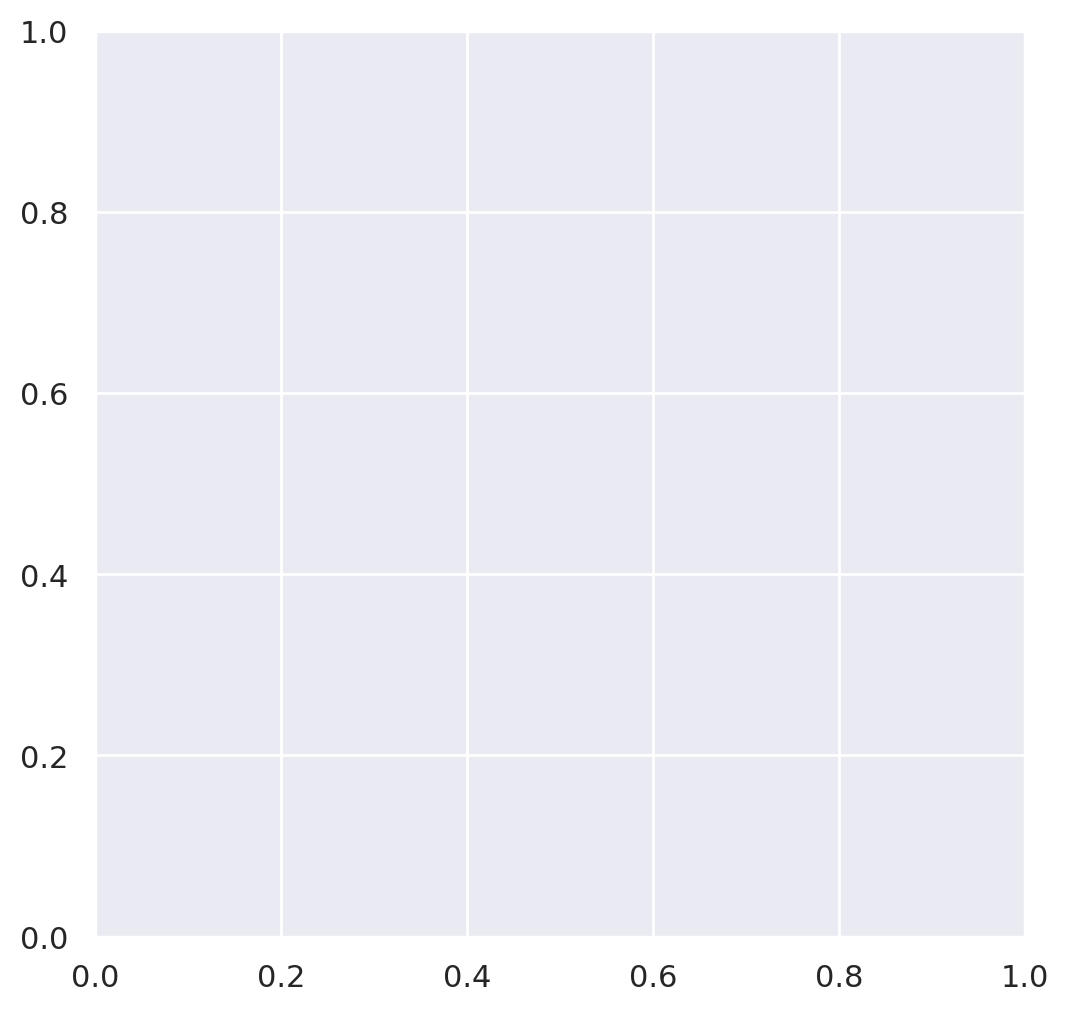

In [312]:
indx = 9506
fig = plt.subplots(figsize=(6,6),dpi=200)
ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

In [ ]:
shap.initjs()
shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [ ]:
error_df[['pred','truth']].describe()

In [ ]:
error_df.groupby('year_issued').error.mean()

In [ ]:
time.time()-time0